In [1]:
include <- function(pkg) {
  if (!suppressMessages(require(pkg, character.only = TRUE)))
    install.packages(pkg, character.only = TRUE)
  suppressMessages(library(pkg, pkg, character.only = TRUE))
}
include("ShortRead")
include("plyr")
include("magick")
include("ggplot2")
include("Biostrings")
include("proxy")
include("pheatmap")

In [2]:
# BiocManager::install("msa")
# include("msa")

In [3]:
BASE_PATH_NR1 = "/data/samples/AIRR-Seq/OURS/S3987Nr1"
BASE_PATH_NR2 = "/data/samples/AIRR-Seq/OURS/S3987Nr2"

SAMPLES = list(
    list(base_path=BASE_PATH_NR1, name="S3987Nr1-PBMC1_heavy"), #1
    list(base_path=BASE_PATH_NR1, name="S3987Nr1-PBMC1_light"), #2
    list(base_path=BASE_PATH_NR1, name="S3987Nr1-RAMOS_heavy"), #3
    list(base_path=BASE_PATH_NR1, name="S3987Nr1-RAMOS_light"), #4
    list(base_path=BASE_PATH_NR2, name="S3987Nr2-PBMC1_heavy"), #5
    list(base_path=BASE_PATH_NR2, name="S3987Nr2-PBMC1_light"), #6
    list(base_path=BASE_PATH_NR2, name="S3987Nr2-RAMOS_heavy"), #7
    list(base_path=BASE_PATH_NR2, name="S3987Nr2-RAMOS_light")  #8
)

EXCLUDE_FROM_DIVERSITY_ANALYSIS = c(
    "S3987Nr1-RAMOS_heavy"
)

In [4]:
# Helpers
get_path_sample <- function(sample_name, base_path = BASE_PATH) {
    return(paste0(base_path, "/", sample_name))
}

get_path_fastq <- function(sample_name, type = "raw", base_path = BASE_PATH) {
    
    if (type == "raw") {
        return(
            paste0(
                get_path_sample(sample_name, base_path),
                "/", sample_name, ".1.fastq"
            )
        )
    } else if (type == "primer_pass") {
        suffix = ".1_primers-pass.fastq"
    } else if (type == "pair_pass"){
        suffix = ".1_primers-pass_pair-pass.fastq"
    } else if (type == "under2") {
        suffix = "_under-2.fastq"
    } else if (type == "atleast2") {
        suffix = "_atleast-2.fastq"
    } else {
        stop(paste0("Unsupported fastq file type: ", type))
    }
    
    return(
        paste0(
            get_path_sample(sample_name, base_path),
            "/", "presto",
            "/", sample_name, suffix
        )
    )
}

get_path_igblast <- function(sample_name, base_path = BASE_PATH) {
    return(
        paste0(
            get_path_sample(sample_name, base_path), 
            "/", "changeo_igblast", 
            "/", sample_name, "_db-pass_with_translation.tsv"
        )
    )
}

get_path_clones <- function(sample_name, clone_file = "groups", base_path = BASE_PATH) {
    
    if (clone_file == "groups") {
        suffix = "_novj_groups.tsv"
    } else if (clone_file == "clones") {
        suffix = "_novj_with_clones.tsv"
    } else if (clone_file == "counts") {
        return(
            paste0(
                get_path_sample(sample_name, base_path),
                "/", "clones", 
                "/", "diversity_novj",
                "/", sample_name, "_clone_counts.tsv"
            )
        )
    } else {
        stop(paste0("Unknown clone_file type: ", clone_file))
    }
    
    return(
        paste0(
            get_path_sample(sample_name, base_path),
            "/", "clones",
            "/", sample_name, suffix
        )
    )
}

get_path_coverages <- function(sample_name, base_path = BASE_PATH) {
    return(
        paste0(
            get_path_sample(sample_name, base_path),
            "/", "clones",
            "/", "diversity_novj",
            "/", sample_name, "_coverages.tsv"
        )
    )
}

get_path_diversity <- function(sample_name, base_path = BASE_PATH) {
    return(
        paste0(
            get_path_sample(sample_name, base_path),
            "/", "clones",
            "/", "diversity_novj",
            "/", sample_name, "_diversity.tsv"
        )
    )
}

get_path_pngs <- function(sample_name, img_type = "abundancy", base_path = BASE_PATH) {
    
    if (img_type == "abundancy") {
        suffix = "_abundancy_curve.png"
    } else if (img_type == "diversity") {
        suffix = "_diversity.png"
    } else if (img_type == "clones") {
        return(
            paste0(
                get_path_sample(sample_name, base_path),
                "/", "clones",
                "/", sample_name, "_with_clones.png"
            )
        )
    } else {
        stop("Image type = ", img_type, " is not supported.")
    }
    
    return(
        paste0(
            get_path_sample(sample_name, base_path),
            "/", "clones",
            "/", "diversity",
            "/", sample_name, suffix
        )
    )
}

read_tsv <- function(filepath) {
    return(read.csv(filepath, sep='\t'))
}

### Characterize sequencing results for each sample

In [5]:
# fp = get_path_fastq(SAMPLES[[1]]$name, type = "atleast2", SAMPLES[[1]]$base_path)
# print(fp)
# qa_summary = ShortRead::qa(fp, type = "fastq")

In [6]:
# report_html(qa_summary, "test.html")

In [7]:
count_reads_fastq <- function(fastq_path) {
    return(
        ShortRead::countFastq(fastq_path)$records
    )
}

In [8]:
res <- sapply(
    SAMPLES,
    function(sample) {
        counts = cbind(
            sample$name,
            count_reads_fastq(get_path_fastq(sample$name, type = "raw", sample$base_path)),
            count_reads_fastq(get_path_fastq(sample$name, type = "primer_pass", sample$base_path)),
            count_reads_fastq(get_path_fastq(sample$name, type = "pair_pass", sample$base_path)),
            count_reads_fastq(get_path_fastq(sample$name, type = "under2", sample$base_path)),
            count_reads_fastq(get_path_fastq(sample$name, type = "atleast2", sample$base_path))
        )
        return(counts)
    }
)

res <- data.frame(t(res))
colnames(res) = c("sample_name", "raw", "primer_pass", "pair_pass", "under2", "atleast2")

res$seq_batch = sapply( strsplit(res$sample_name, "-"), function(x) {x[1]} )
res$sample_type = sapply( strsplit(res$sample_name, "-"), function(x) {x[2]} )

for (col_idx in 2:6) {
    res[, col_idx] = as.integer( res[, col_idx] )
}

res

sample_name,raw,primer_pass,pair_pass,under2,atleast2,seq_batch,sample_type
<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
S3987Nr1-PBMC1_heavy,293087,293087,293087,125760,14064,S3987Nr1,PBMC1_heavy
S3987Nr1-PBMC1_light,264459,264459,264459,108203,13384,S3987Nr1,PBMC1_light
S3987Nr1-RAMOS_heavy,160952,160952,160952,28,5,S3987Nr1,RAMOS_heavy
S3987Nr1-RAMOS_light,69991,69991,69991,25974,3791,S3987Nr1,RAMOS_light
S3987Nr2-PBMC1_heavy,4130140,4130140,4130140,1309942,187173,S3987Nr2,PBMC1_heavy
S3987Nr2-PBMC1_light,3756935,3756935,3756935,1099571,170346,S3987Nr2,PBMC1_light
S3987Nr2-RAMOS_heavy,2273707,2273707,2273707,499252,81351,S3987Nr2,RAMOS_heavy
S3987Nr2-RAMOS_light,1042385,1042385,1042385,270362,42482,S3987Nr2,RAMOS_light


Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”


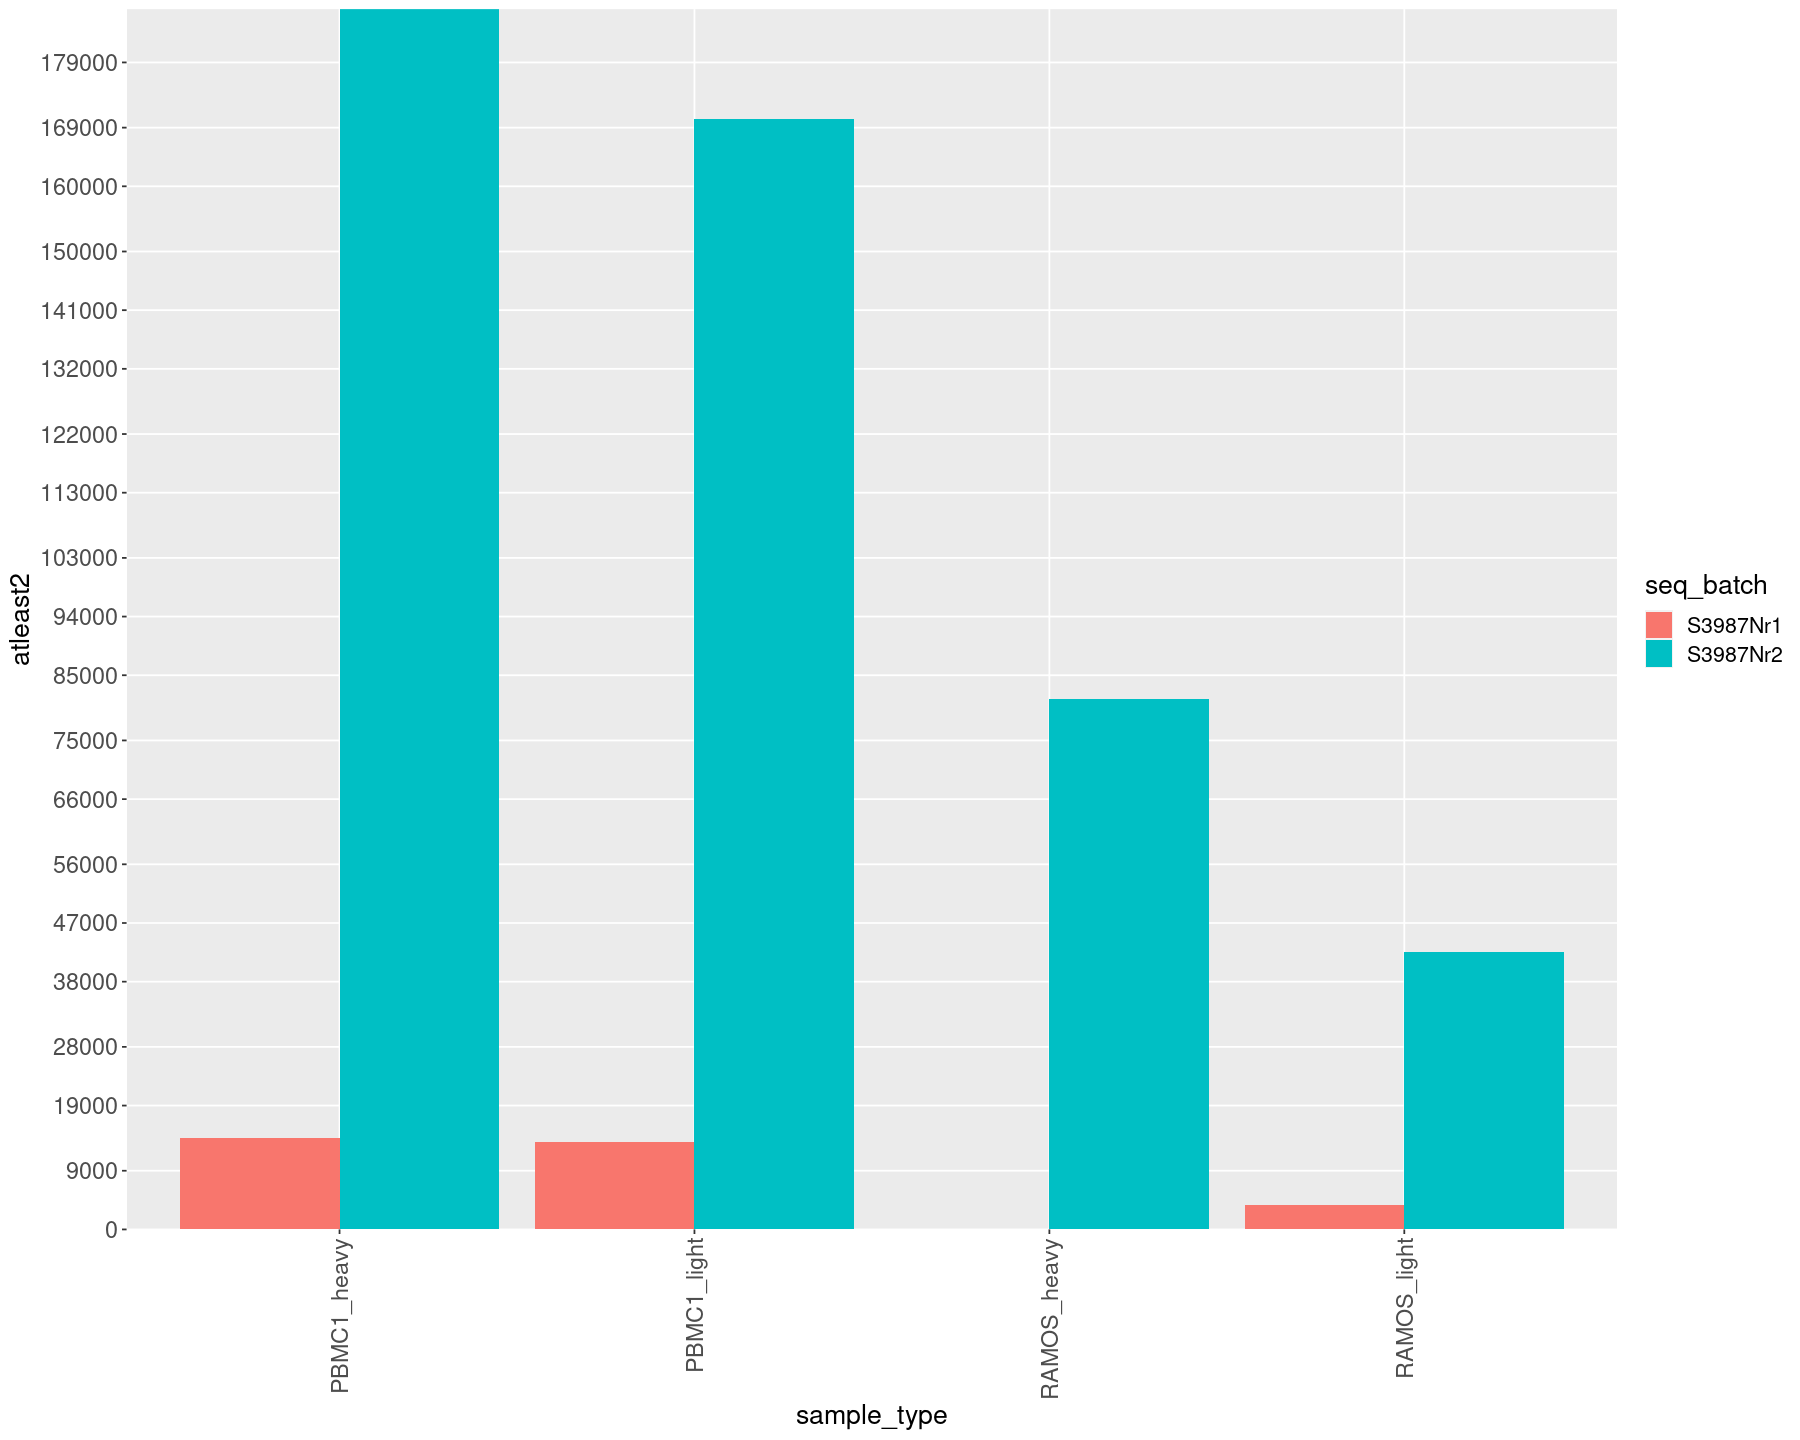

In [9]:
colname = "atleast2"

saved <- options(repr.plot.width=15, repr.plot.height=12)

num_ticks = 20
max_val = max(res[colname])
min_val = min(res[colname])

tick_spacing = plyr::round_any( (max_val - min_val) / num_ticks, 100)

g = (
    ggplot2::ggplot(data = res, aes(fill = seq_batch, x = sample_type, y = get(colname))) 
    + ggplot2::geom_bar(stat = "identity", position = "dodge")  # dodge, stack
    + ggplot2::scale_y_discrete(
        limit = plyr::round_any(seq(min_val, max_val, tick_spacing), 1000)
    )
    + ggplot2::ylab(colname)
    + ggplot2::theme(text = element_text(size = 16),
            axis.text = element_text(size=14), 
            axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
    )
print(g)

options(saved)

### Compare clone counts

In [10]:
columnar_dataframe_builder <- function(values_vec, colnames) {
    df = data.table::transpose(data.frame(values_vec))
    colnames(df) = colnames
    return(df)
}

aggregate_tsvs <- function(samples, path_builder, mode = "headers", nrows = 5, processor = NULL) {
    
    if (!(mode %in% c("headers", "processor"))) {
        stop(paste0("Mode not supported: ", mode))
    }
    
    df_res = data.frame()
    for (i in 1:length(samples)) {
        
        sample = samples[[i]]
        filepath = path_builder(sample$name, sample$base_path)
        
        if (file.exists(filepath)) {
            
            if (mode == "headers") {
                tsv_head = head(read_tsv(filepath), n = nrows)
                tsv_nrow = nrow(tsv_head)
                if (tsv_nrow > 0) {
                    df_annotated = cbind(sample$name, 1:tsv_nrow, tsv_head)
                    df_res = plyr::rbind.fill(df_res, df_annotated)
                } else {
                    print(paste0("0 rows for: ", filepath))
                }
            } else if (mode == "processor") {
                tsv = read_tsv(filepath)
                df_processed = processor(tsv)
                df_annotated = cbind(sample$name, df_processed)
                df_res = plyr::rbind.fill(df_res, df_annotated)
            }
        
        } else {
            print(paste0("Filepath not found: ", filepath))
        }
    }
    ncol = ncol(df_res)
    colnames(df_res) <- c("sample_name", "rank", colnames(df_res)[3:ncol])
    return(df_res)
}

In [11]:
clone_counts = aggregate_tsvs(
    SAMPLES,
    function(name, base_path) {get_path_clones(name, "counts", base_path)},
    nrows = 10
)
clone_counts

[1] "Filepath not found: /data/samples/AIRR-Seq/OURS/S3987Nr1/S3987Nr1-RAMOS_heavy/clones/diversity_novj/S3987Nr1-RAMOS_heavy_clone_counts.tsv"


sample_name,rank,clone_id,seq_count,copy_count,seq_freq,copy_freq
<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
S3987Nr1-PBMC1_heavy,1,537,1619,25027,0.1236538608,0.1935396560
S3987Nr1-PBMC1_heavy,2,359,716,10839,0.0546857099,0.0838205271
S3987Nr1-PBMC1_heavy,3,866,776,8974,0.0592683113,0.0693980450
S3987Nr1-PBMC1_heavy,4,437,527,8121,0.0402505155,0.0628015961
S3987Nr1-PBMC1_heavy,5,1259,530,7437,0.0404796456,0.0575120638
S3987Nr1-PBMC1_heavy,6,1161,333,3130,0.0254334377,0.0242050235
S3987Nr1-PBMC1_heavy,7,1205,220,1924,0.0168028718,0.0148787429
S3987Nr1-PBMC1_heavy,8,896,206,1868,0.0157335981,0.0144456818
S3987Nr1-PBMC1_heavy,9,1093,180,1681,0.0137478042,0.0129995669


Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”


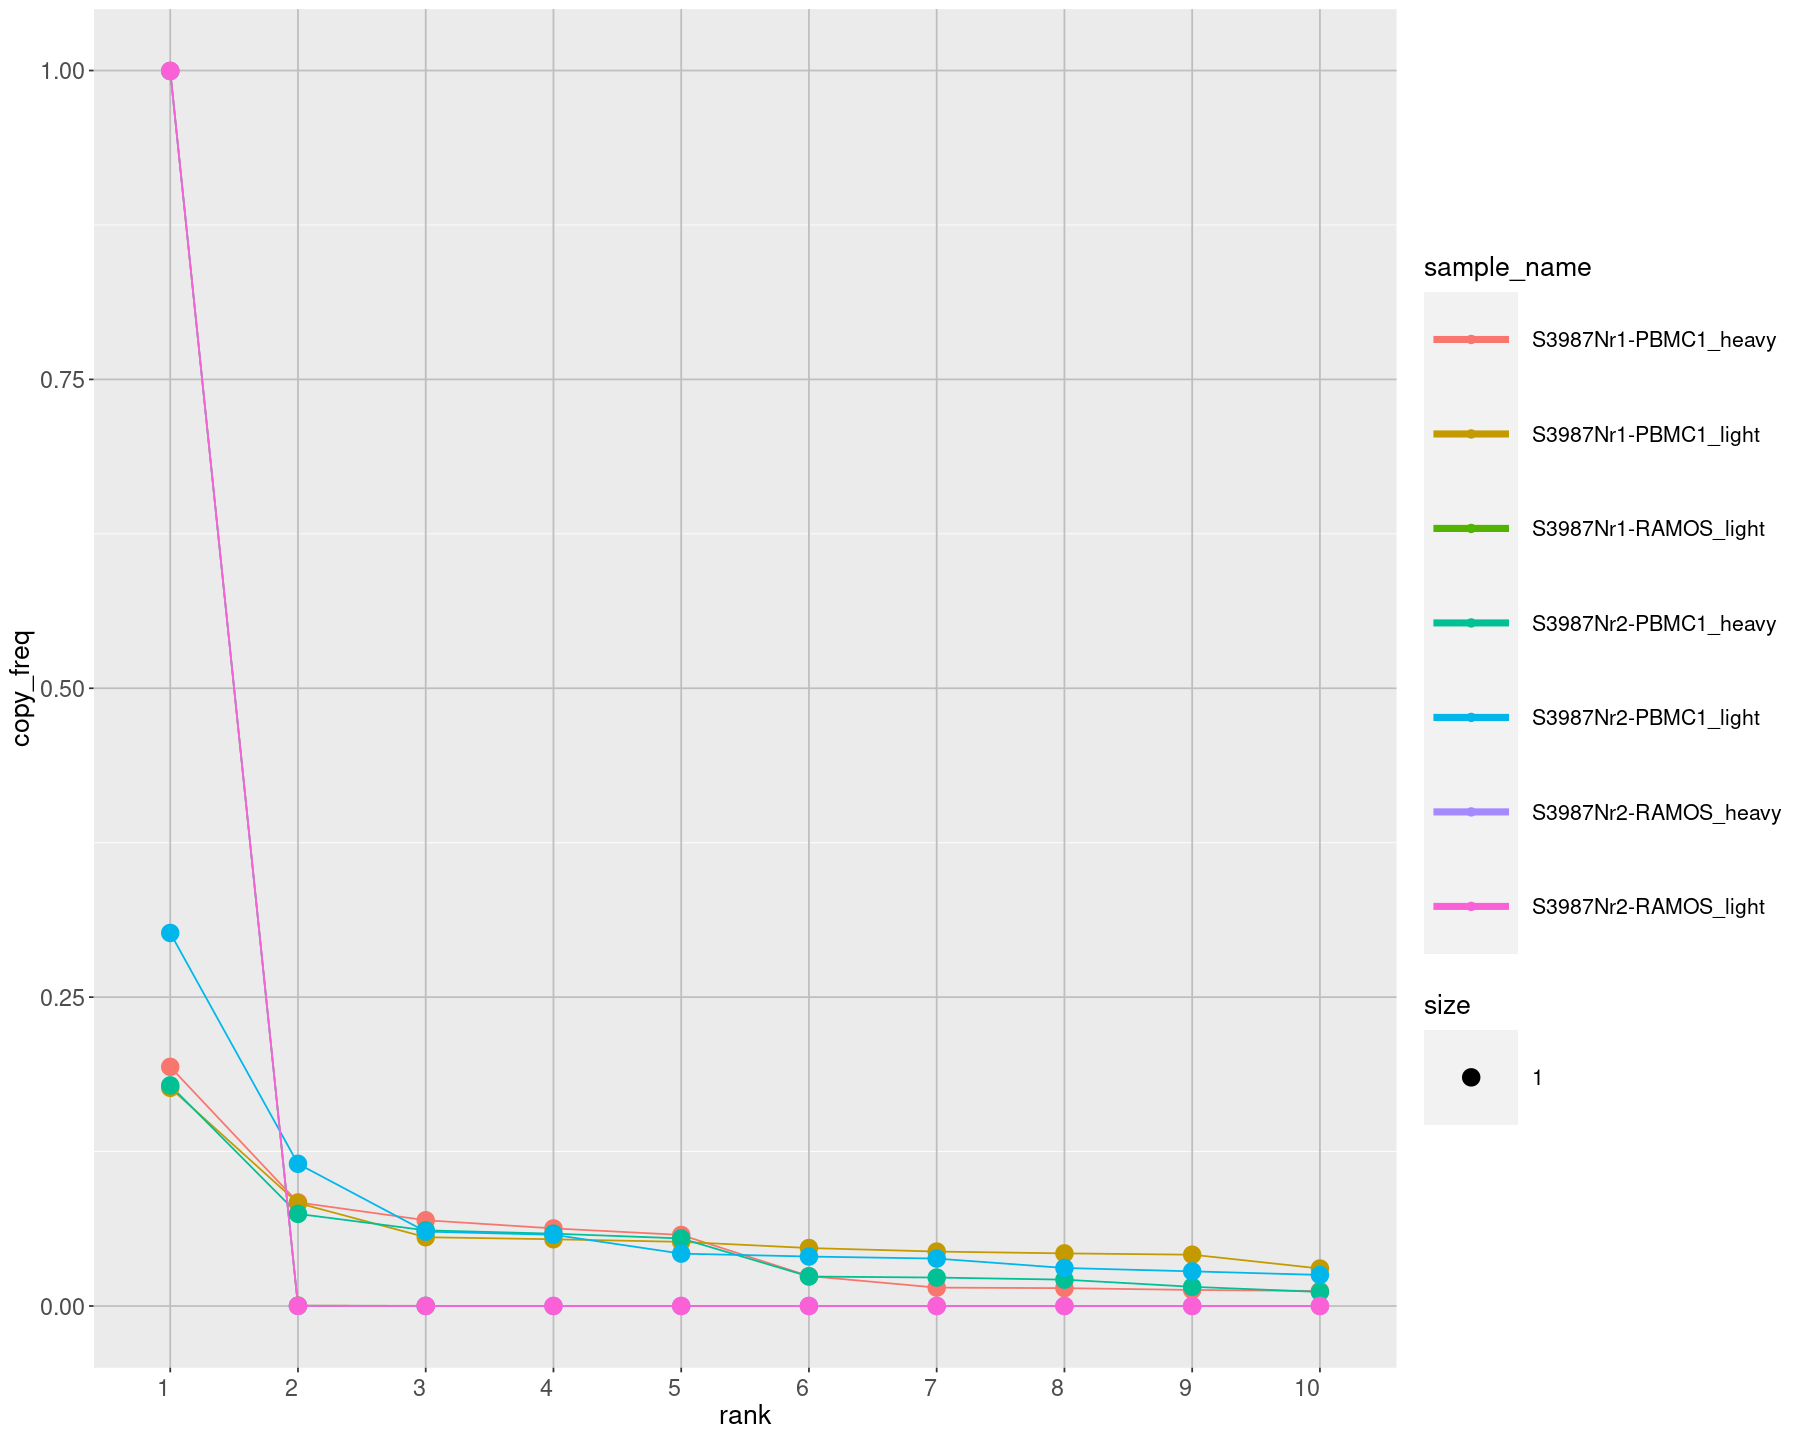

In [12]:
colname = "copy_freq"  # seq_count, copy_count, seq_freq, copy_freq

saved <- options(repr.plot.width=15, repr.plot.height=12)

g = (
    ggplot2::ggplot(data = clone_counts, aes(x = rank, y = get(colname))) 
    + ggplot2::geom_line(aes(color = sample_name))
    + ggplot2::geom_point(aes(color = sample_name, size = 1))
    + ggplot2::scale_x_discrete(limits = 1:10)
#     + scale_y_discrete(limits = seq(0, 1, 0.1))
    + ggplot2::ylab(colname)
    + ggplot2::theme(text = element_text(size = 16),
            axis.text = element_text(size=14), 
            axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1),
            legend.key.size = unit(2, "cm"),
            legend.key.width = unit(2, "cm"))
    + ggplot2::theme(panel.grid.major = element_line(colour = "gray"))
    + ggplot2::guides(color = guide_legend(override.aes = list(size = 2)))
    )
print(g)

options(saved)


### Top k clones similarity

In [13]:
sample_pair = list(SAMPLES[[1]], SAMPLES[[5]])


tsv1 = read_tsv(get_path_clones(sample_pair[[1]]$name, "clones", sample_pair[[1]]$base_path))
tsv2 = read_tsv(get_path_clones(sample_pair[[2]]$name, "clones", sample_pair[[2]]$base_path))

In [14]:
align_pairwise <- function(seq1, seq2) {
    return(
        Biostrings::pairwiseAlignment(seq1, seq2, scoreOnly=TRUE)
    )
}

sequence_identity <- function(seq1, seq2) {
    align = Biostrings::pairwiseAlignment(seq1, seq2)
    return(
        Biostrings::pid(align, "PID2")
    )
}

In [15]:
nclones = 10
feature = "sequence"
similarity_func = sequence_identity


seqs_1 = tsv1[1:nclones, feature]
seqs_2 = tsv2[1:nclones, feature]

d = proxy::dist(as.list(seqs_1), as.list(seqs_2), method = similarity_func)
colnames(d) = paste0("seqs?_", 1:nclones)
rownames(d) = paste0("seqs?_", 1:nclones)

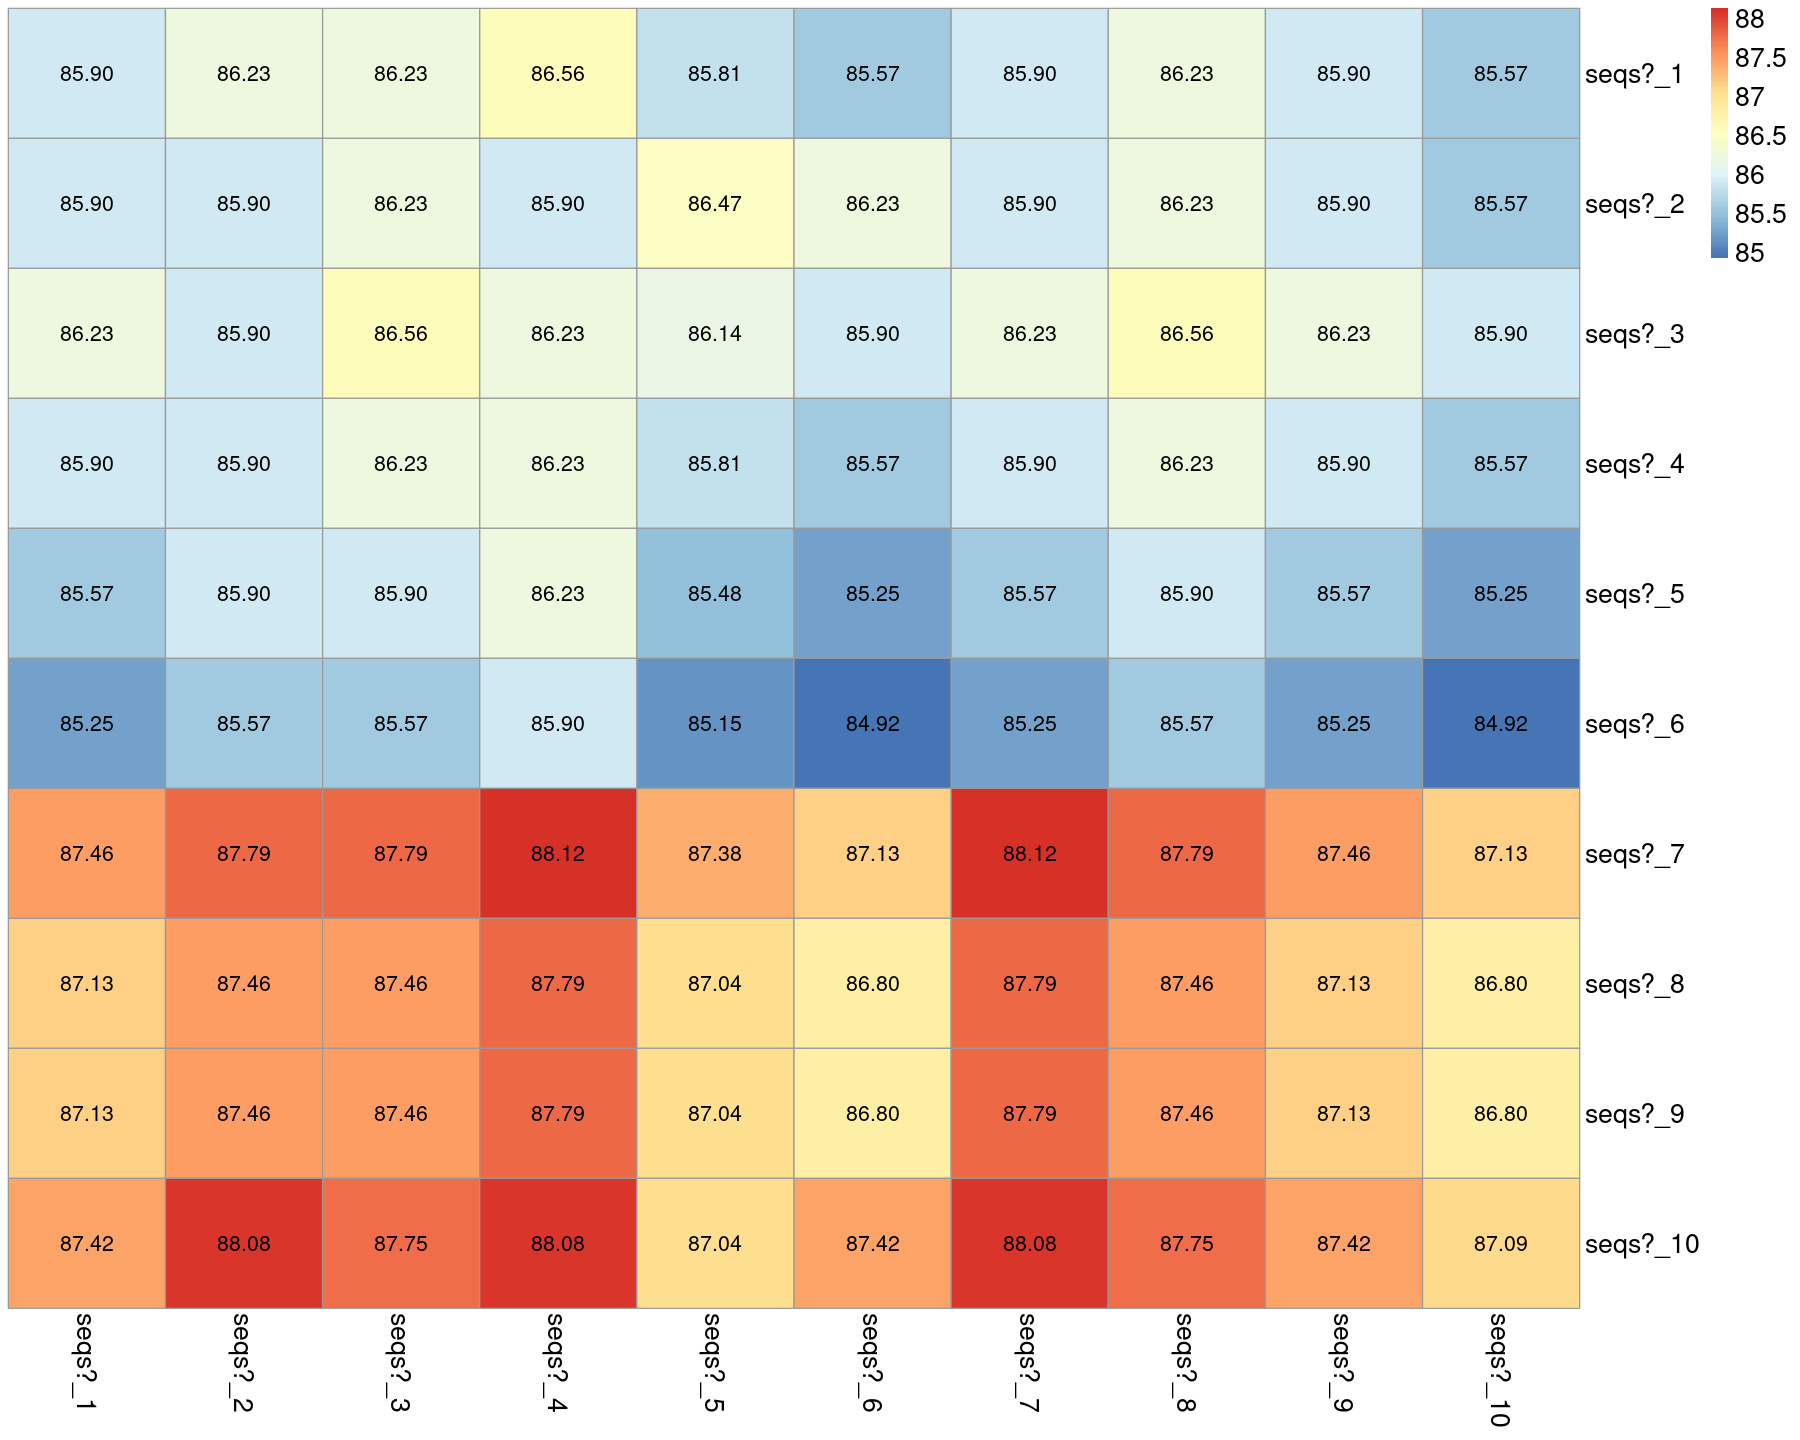

In [16]:
saved <- options(repr.plot.width=15, repr.plot.height=12)

pheatmap::pheatmap(
    d, 
    cluster_rows=FALSE, cluster_cols=FALSE, 
    show_rownames=TRUE, show_colnames=TRUE, 
    display_numbers=TRUE, number_color = "black", 
    fontsize=16)

options(saved)

### Abundancy and diversity comparisons among samples

In [17]:
coverages_df = aggregate_tsvs(
    SAMPLES, 
    function(sample_name, base_path) {get_path_coverages(sample_name, base_path)}, 
    nrows = 10
)
coverages_df

[1] "Filepath not found: /data/samples/AIRR-Seq/OURS/S3987Nr1/S3987Nr1-RAMOS_heavy/clones/diversity_novj/S3987Nr1-RAMOS_heavy_coverages.tsv"


sample_name,rank,X1.order,coverages
<chr>,<int>,<int>,<dbl>
S3987Nr1-PBMC1_heavy,1,1,0.9726591
S3987Nr1-PBMC1_heavy,2,2,0.9999275
S3987Nr1-PBMC1_heavy,3,3,0.9999999
S3987Nr1-PBMC1_heavy,4,4,1.0000000
S3987Nr1-PBMC1_heavy,5,5,1.0000000
S3987Nr1-PBMC1_heavy,6,6,1.0000000
S3987Nr1-PBMC1_heavy,7,7,1.0000000
S3987Nr1-PBMC1_heavy,8,8,1.0000000
S3987Nr1-PBMC1_heavy,9,9,1.0000000


In [18]:
diversity <- read_tsv(
    get_path_diversity(SAMPLES[[1]]$name, SAMPLES[[1]]$base_path)
)

interpret_diversity <- function(diversity_df) {

    extract_div_by_q <- function(q) {diversity_df[diversity$q == q, ]$d}
    
    species_richness <- extract_div_by_q(0)
    D_1 <- extract_div_by_q(1)
    D_2 <- extract_div_by_q(2)
    D_3 <- extract_div_by_q(3)
    D_4 <- extract_div_by_q(4)
    shannon_index <- log(D_1, 2)
    gini_simpson_index <- 1 - 1/D_2
    
    res = columnar_dataframe_builder(
        values_vec = c(species_richness, D_1, D_2, D_3, D_4, shannon_index, gini_simpson_index),
        colnames = c("Species_richness_D_0", "D_1", "D_2", "D_3", "D_4", "Shannon_uncertainty", "Gini_simpson_prob")
    )
    
#     res = data.frame(
#         c("Species_richness_D_0", "D_1", "D_2", "D_3", "D_4", "Shannon_uncertainty", "Gini_simpson_prob"), 
#         c(species_richness, D_1, D_2, D_3, D_4, shannon_index, gini_simpson_index)
#     )
    return(res)
}

In [19]:
# head(diversity)
# interpret_diversity(diversity)
aggregate_tsvs(
    SAMPLES,
    get_path_diversity,
    mode = "processor",
    processor = interpret_diversity
)

[1] "Filepath not found: /data/samples/AIRR-Seq/OURS/S3987Nr1/S3987Nr1-RAMOS_heavy/clones/diversity_novj/S3987Nr1-RAMOS_heavy_diversity.tsv"


sample_name,rank,D_1,D_2,D_3,D_4,Shannon_uncertainty,Gini_simpson_prob
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S3987Nr1-PBMC1_heavy,1195.810,212.967404,36.240621,20.271929,15.633808,7.73448883,0.972406654
S3987Nr1-PBMC1_light,515.185,66.893252,26.184925,18.154490,14.716206,6.06378877,0.961810087
S3987Nr1-RAMOS_light,2.850,1.016414,1.004290,1.003218,1.002860,0.02348788,0.004271336
S3987Nr2-PBMC1_heavy,2125.950,232.448895,52.420712,28.280374,20.919460,7.86076976,0.980923571
S3987Nr2-PBMC1_light,809.965,37.842693,10.970218,7.224447,5.971870,5.24194283,0.908844111
S3987Nr2-RAMOS_heavy,27.885,1.011813,1.002166,1.001624,1.001443,0.01694333,0.002161078
S3987Nr2-RAMOS_light,10.295,1.014122,1.003168,1.002376,1.002111,0.02023107,0.003157883


### 2-sample comparison

In [20]:
pbmc_nr1_changeo = read_tsv(get_path_igblast(SAMPLES[[1]]$name, SAMPLES[[1]]$base_path))
pbmc_nr2_changeo = read_tsv(get_path_igblast(SAMPLES[[5]]$name, SAMPLES[[5]]$base_path))

pbmc_nr1_changeo = pbmc_nr1_changeo[order(-pbmc_nr1_changeo$duplicate_count), ]
pbmc_nr2_changeo = pbmc_nr2_changeo[order(-pbmc_nr2_changeo$duplicate_count), ]

In [21]:
sum(pbmc_nr1_changeo$duplicate_count)
sum(pbmc_nr2_changeo$duplicate_count)

[1] 374

[1] 2360616

In [22]:
# View top duplicate sequences for both, especially cprimer and c_call
columns_sel = c("sequence_id", "c_call", "cprimer", "duplicate_count", "cdr3")
head(pbmc_nr1_changeo[, columns_sel], 20)
head(pbmc_nr2_changeo[, columns_sel], 20)

,sequence_id,c_call,cprimer,duplicate_count,cdr3
,<chr>,<chr>,<chr>,<int>,<chr>
7,M03234:246:000000000-DCH35:1:1101:16395:10360,IGHM,AGACGAGGGGGAAAAGGGTTGGGGCGG,67,GCGAGTGGTCAACATGATTACGATTTTTGGAGTGGCTCGACCCCAAGCTAC
3,M03234:246:000000000-DCH35:1:1101:18526:23456,IGHD,ACCCTGATATGATGGGGAACACATCCG,48,GCGAGCCTGGGTGGAACTACGTTTGACTAC
2,M03234:246:000000000-DCH35:1:1101:14762:3606,IGHM,AGACGAGGGGGAAAAGGGTTGGGGCGG,40,GCGAAAGAACAATACTATGGTGGTGAGATGGACGTC
5,M03234:246:000000000-DCH35:1:1101:25667:14300,IGHM,AGACGAGGGGGAAAAGGGTTGGGGCGG,39,GCAAAAGGTGTGGCTCCTCAGACTCGACTGGCCTACTACGGTATGGACGTC
6,M03234:246:000000000-DCH35:1:1101:21019:4106,IGHM,AGACGAGGGGGAAAAGGGTTGGGGCGG,18,GCAAAAGGTGTGGCTCCTCAGACTCGACTGGCCTACTACGGTATGGACGTC
15,M03234:246:000000000-DCH35:1:1102:20209:17104,IGHM,AGACGAGGGGGAAAAGGGTTGGGGCGG,13,GCGAGAGATGGTGGTCGGGGATATTGTAGTGGTGGTAACTGTTACGCGGACTGGTACTTCGATCTC
1,M03234:246:000000000-DCH35:1:1102:12599:25334,IGHD,ACCCTGATATGATGGGGAACACATCCG,7,GCGAGAGGACTGGGGGGCAGTAACTACGTTGACTAC
11,M03234:246:000000000-DCH35:1:1101:20199:13823,IGHM,AGACGAGGGGGAAAAGGGTTGGGGCGG,7,GCAAAAGATCTAGGATATTGTAGTGGTGGTAGCTGCTCTACCTTTGACTAC
20,M03234:246:000000000-DCH35:1:1101:13298:21677,IGHD,ACCCTGATATGATGGGGAACACATCCG,7,GCGAGAGGACTGGGGGGCAGTAACTACGTTGACTAC


,sequence_id,c_call,cprimer,duplicate_count,cdr3
,<chr>,<chr>,<chr>,<int>,<chr>
4,M03234:253:000000000-JT9CK:1:1103:11722:19374,IGHA,GCTCAGCGGGAAGACCTTGGGGCTGGT,111636,GCGAGAGAGTATGATTTTTGGAGTGGCTATTATAATGCATTTGATATC
18,M03234:253:000000000-JT9CK:1:2104:4961:15561,IGHA,GCTCAGCGGGAAGACCTTGGGGCTGGT,73277,GCGAAAAATCATGATAGTAGTCCCGGAGTGTTTCAAGTC
10,M03234:253:000000000-JT9CK:1:2104:7424:14742,IGHA,GCTCAGCGGGAAGACCTTGGGGCTGGT,62237,GCGACCGCCGGATATAGATCCAATGGGACACTTTTTGACTAC
65,M03234:253:000000000-JT9CK:1:1104:10504:13806,IGHM,AGACGAGGGGGAAAAGGGTTGGGGCGG,51380,GCGAGAGTCACTAGGACTGGAACTCCCCACGTCAGTGACTAC
1,M03234:253:000000000-JT9CK:1:2102:13415:13194,IGHA,GCTCAGCGGGAAGACCTTGGGGCTGGT,41311,GCGAGAGAGGAGTATAAGTATGGTTTGGGGGCTTTGGATATC
27,M03234:253:000000000-JT9CK:1:1107:12308:16923,IGHA,GCTCAGCGGGAAGACCTTGGGGCTGGT,37748,GCGAGAGAGTATGATTTTTGGAGTGGCTATTATAATGCATTTGATATC
80,M03234:253:000000000-JT9CK:1:2114:4714:13643,IGHA,GCTCAGCGGGAAGACCTTGGGGCTGGT,26829,GCGAGAGAGTATGATTTTTGGAGTGGCTATTATAATGCATTTGATATC
169,M03234:253:000000000-JT9CK:1:2113:12062:14000,IGHA,GCTCAGCGGGAAGACCTTGGGGCTGGT,15798,TGTAAAAGTCCCATAGGAAAGGGCCCCGAAGACTCC
46,M03234:253:000000000-JT9CK:1:2104:9742:16500,IGHA,GCTCAGCGGGAAGACCTTGGGGCTGGT,13209,GCGAGAGAGGAGTATAAGTATGGTTTGGGGGCTTTGGATATC


In [23]:
# Statistically test the difference in proportion for isotypes IGHM and IGHA between the 2

### Join plots

In [24]:
# magick::image_append(magick::image_scale(img, "100"), stack = TRUE)

In [25]:
img1 = magick::image_read(get_path_pngs(SAMPLES[[1]]$name, "abundancy", SAMPLES[[1]]$base_path))
img2 = magick::image_read(get_path_pngs(SAMPLES[[2]]$name, "abundancy", SAMPLES[[2]]$base_path))
img3 = magick::image_read(get_path_pngs(SAMPLES[[3]]$name, "abundancy", SAMPLES[[3]]$base_path))
comb_img = magick::image_append(c(img1, img2, img3), stack=TRUE)
magick::image_write(comb_img, path = "tiger.png", format = "png")

ERROR: Error in magick_image_readpath(path, density, depth, strip, defines): R: unable to open image `/data/samples/AIRR-Seq/OURS/S3987Nr1/S3987Nr1-PBMC1_heavy/clones/diversity/S3987Nr1-PBMC1_heavy_abundancy_curve.png': No such file or directory @ error/blob.c/OpenBlob/2924


In [ ]:
img1 = magick::image_read(get_path_pngs(SAMPLES[[1]]$name, "diversity", SAMPLES[[1]]$base_path))
img2 = magick::image_read(get_path_pngs(SAMPLES[[2]]$name, "diversity", SAMPLES[[2]]$base_path))
img3 = magick::image_read(get_path_pngs(SAMPLES[[3]]$name, "diversity", SAMPLES[[3]]$base_path))
# img4 = magick::image_read(get_path_pngs(SAMPLES[[4]]$name, "clones", SAMPLES[[4]]$base_path))

comb_img = comb_img = magick::image_append(c(img1, img2, img3), stack=TRUE)
magick::image_write(comb_img, path = "tiger.png", format = "png")

In [ ]:
img1 = magick::image_read(get_path_pngs(SAMPLES[[1]]$name, "clones", SAMPLES[[1]]$base_path))
img2 = magick::image_read(get_path_pngs(SAMPLES[[2]]$name, "clones", SAMPLES[[2]]$base_path))
img3 = magick::image_read(get_path_pngs(SAMPLES[[3]]$name, "clones", SAMPLES[[3]]$base_path))
# img4 = magick::image_read(get_path_pngs(SAMPLES[[4]]$name, "clones", SAMPLES[[4]]$base_path))

comb_img = comb_img = magick::image_append(c(img1, img2, img3), stack=TRUE)
magick::image_write(comb_img, path = "tiger.png", format = "png")